In [1]:
from plantclef.spark import get_spark
from pathlib import Path
from pyspark.sql import functions as F
import numpy as np
from plantclef.serde import (
    deserialize_mask,
    serialize_mask,
    deserialize_image,
    serialize_image,
)
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
spark = get_spark(cores=8, memory="30g", app_name="masking-notebook")
root = Path("~/shared/plantclef/data").expanduser().as_posix()
masks = spark.read.parquet(f"{root}/masking/test_2024_v2/data")
masks = masks.unpivot(
    "image_name", [c for c in masks.columns if "mask" in c], "mask_type", "mask"
).cache()
masks.printSchema()
masks.show(5)

images = spark.read.parquet(f"{root}/parquet/test_2024").cache()
images.printSchema()
images.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/06 02:22:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/06 02:22:18 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


root
 |-- image_name: string (nullable = true)
 |-- mask_type: string (nullable = false)
 |-- mask: binary (nullable = true)



+--------------------+-----------+--------------------+
|          image_name|  mask_type|                mask|
+--------------------+-----------+--------------------+
|CBN-PdlC-B4-20190...|  leaf_mask|[78 9C EC D8 BD A...|
|CBN-PdlC-B4-20190...|flower_mask|[78 9C EC DD B1 B...|
|CBN-PdlC-B4-20190...| plant_mask|[78 9C EC DD BF B...|
|CBN-PdlC-B4-20190...|  sand_mask|[78 9C EC DC BB A...|
|CBN-PdlC-B4-20190...|  wood_mask|[78 9C EC DD CD 8...|
+--------------------+-----------+--------------------+
only showing top 5 rows

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)



+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-PdlC-C6-20130...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-Pla-D3-201508...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C3-20190...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C1-20200...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B2-20160...|/test_2024/images...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [3]:
@F.udf("binary")
def merge_masks(masks: list[bytearray]) -> bytearray:
    masks = [deserialize_mask(m) for m in masks]
    merged = np.bitwise_or.reduce(masks)
    return serialize_mask(merged)


combined_mask = (
    masks.where(F.col("mask_type").isin(["plant_mask", "flower_mask", "leaf_mask"]))
    .groupBy("image_name")
    .agg(F.collect_list("mask").alias("masks"))
    .select("image_name", merge_masks(F.col("masks")).alias("mask"))
)
combined_mask.printSchema()
combined_mask.show(5)

root
 |-- image_name: string (nullable = true)
 |-- mask: binary (nullable = true)



+--------------------+--------------------+
|          image_name|                mask|
+--------------------+--------------------+
|CBN-PdlC-A1-20160...|[78 9C EC DD C1 B...|
|CBN-PdlC-A3-20140...|[78 9C EC DD CF 8...|
|CBN-PdlC-A3-20170...|[78 9C EC DD B1 9...|
|CBN-PdlC-A4-20150...|[78 9C EC DD BD 8...|
|CBN-PdlC-A4-20150...|[78 9C EC DD BD B...|
+--------------------+--------------------+
only showing top 5 rows



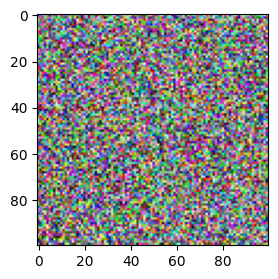

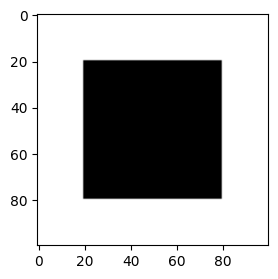

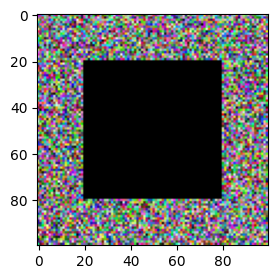

[127.2240625 127.145625  126.88125  ]


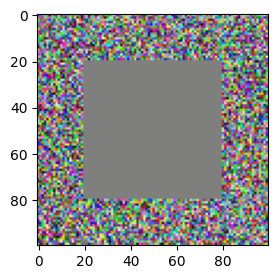

In [4]:
# apply a mask in a toy example
img = (np.random.random((100, 100, 3)) * 255).astype(np.uint8)
mask = np.ones((100, 100), dtype=np.uint8)
mask[20:80, 20:80] = 0

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.show()
plt.figure(figsize=(3, 3))
plt.imshow(mask, cmap="gray")
plt.show()

# now do the masking
masked = img * mask[:, :, None]
plt.figure(figsize=(3, 3))
plt.imshow(masked)
plt.show()

# with mean fill
# with mean fill
masked_pixels = masked[mask == 1]  # Extract masked pixels
if masked_pixels.size > 0:  # Check if there are any pixels to calculate the mean from
    print(masked_pixels.mean(axis=0))
    mean_color = masked_pixels.mean(axis=0)  # Calculate mean color
    masked[mask == 0] = mean_color.astype(np.uint8)
plt.figure(figsize=(3, 3))
plt.imshow(masked)
plt.show()

root
 |-- image_name: string (nullable = true)
 |-- data: binary (nullable = true)



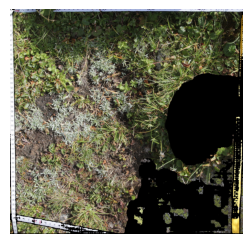

In [5]:
@F.udf("binary")
def apply_mask(image: bytearray, mask: bytearray, fill_mean: bool = False) -> bytearray:
    image = deserialize_image(image)
    mask = deserialize_mask(mask)
    masked = image * mask[:, :, None]
    if fill_mean:
        masked_pixels = masked[mask == 1]
        if masked_pixels.size > 0:
            mean_color = masked_pixels.mean(axis=0)
            masked[mask == 0] = mean_color.astype(np.uint8)
    return serialize_image(Image.fromarray(masked))


masked_images = images.join(combined_mask.limit(5), on="image_name").select(
    "image_name", apply_mask(F.col("data"), F.col("mask")).alias("data")
)
masked_images.printSchema()
row = masked_images.first()

img = deserialize_image(row.data)
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.show()

root
 |-- image_name: string (nullable = true)
 |-- data: binary (nullable = true)



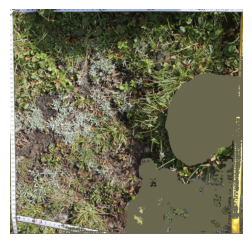

In [6]:
masked_images = images.join(combined_mask.limit(5), on="image_name").select(
    "image_name", apply_mask(F.col("data"), F.col("mask"), F.lit(True)).alias("data")
)
masked_images.printSchema()
row = masked_images.first()

img = deserialize_image(row.data)
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.show()